<a href="https://colab.research.google.com/github/mehlmanmichael/Coursera_Capstone/blob/main/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction / Business Problem
## Motivation
My brother lives in Houston, Texas.  He is recently unemployed and thought that this would be a great time to start a new company.  I plan to help him figure out what type of businesses are under-represented or over-represented in different areas of the city near where he lives.

If a business is under-represented relative in an area relative to that area's peers, then it might be worth researching more to see if it makes sense to pursue that type of venture.
## Approach
### Cluster
First we will need to cluster the area around my brother's house to see what areas are similar in order to generate a peer group.  I had several ideas on how to do this:
* Use neighborhoods: I found a list of Houston neighborhoods on wikipedia; however, I could not find corresponsing lat/long information
* Use zip codes: All Houston area zip codes start with 770XX.  I did this project first using this approach, but the areas were too coarse (some zip codes are large).
* __Create a lat/long grid:__ I chose this approach because it gave sufficient resolution on the areas surrounding my brother's house.

I used a similar approach (kmeans) to break a 10x10 lat/long grid of 100 areas into 10 different clusters or "types" of areas.  I then used these areas for the next part...

### Find area characteristics relative to cluster means
I took the mean of the number of each different type of venue per cluster and compared it to the representation of that type of venue in each region.  I then looked at a couple of these venu types (some that were of interest) and looked for the area where that venue type was most under-represented.  These are good candidate businesses.

## Required Data
* End points for the bounding box of lat/long to consider (obtained manually via google maps)
* Foursquare data on top venues in each of these areas (used both for clustering and then to compare to average cluster properties).

# Data

## Import libraries and load API keys
API keys are loaded through an import for security as below.

In [93]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import matplotlib.pyplot as plt
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image 
from IPython.core.display import HTML 
import folium # mapping library
from folium.features import DivIcon
from sklearn.cluster import KMeans
import sklearn.utils
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import geopy.distance
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Foursquare API credentials are stored on my google drive in a .py file.  Load them here.
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
libpath = '/content/drive/My Drive/Programming/Python/Coursera Data Science Capstone/'
sys.path.append(libpath)
import keys
drive.flush_and_unmount()
#print(keys.CLIENT_ID+keys.CLIENT_SECRET+keys.ACCESS_TOKEN)
VERSION = '20180604'
LIMIT = 50

Mounted at /content/drive


## Get Houston neighborhoods and lat/long

### Zip code approach (too coarse)

In [ ]:
geolocator = Nominatim(user_agent='explorer')
location = geolocator.geocode('Houston, Texas')
hlat = location.latitude
hlon = location.longitude
regs = ['770{:02d}'.format(i) for i in range(100)]
locs = [geolocator.geocode(reg+', Texas') for reg in regs]
lats = [loc.latitude if loc is not None else None for loc in locs]
lons = [loc.longitude if loc is not None else None for loc in locs]

### Lat/Long grid approach (this is what I ultimately used)

In [258]:
clat, clon = 29.72924406953473, -95.44219156375291
lat_num, lon_num = 10, 10
desired_radius = 900.# units in meters
lat_spacing, lon_spacing = 0., 0.
while geopy.distance.distance((clat, clon), (clat + lat_spacing, clon)).m < 2*desired_radius:
  lat_spacing += .001
while geopy.distance.distance((clat, clon), (clat, clon + lon_spacing)).m < 2*desired_radius:
  lon_spacing += .001
latlist = np.arange(clat-lat_num*lat_spacing/2., clat+lat_num*lat_spacing/2., lat_spacing)
lonlist = np.arange(clon-lon_num*lon_spacing/2., clon+lon_num*lon_spacing/2., lon_spacing)
regs, lats, lons = [], [], []
i = 0
for lat in latlist:
  for lon in lonlist:
    regs.append(i)
    lats.append(lat)
    lons.append(lon)
    i += 1
radius = desired_radius * 2. # add some overlap
print('Search radius in meters is: '+str(round(radius,2)))

Search radius in meters is: 1800.0


Convert either of the data sources to dataframe.

In [259]:
df = pd.DataFrame({'reg':regs,'lat':lats,'lon':lons}).set_index('reg')

## Get the Foursquare data

In [260]:
LIMIT = 100
def getNearbyVenues(regs, lats, lons, radius=1000):
    venues_list=[]
    for reg, lat, lon in zip(regs, lats, lons):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(keys.CLIENT_ID, keys.CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        try:
          results = requests.get(url).json()["response"]['groups'][0]['items']
          venues_list.append([(reg, lat, lon, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])
        except:
          print('Error getting data')
          venues_list.append([(reg, lat, lon, None, None, None, None)])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['reg', 'lat', 'lon', 'venue', 'venue_lat', 'venue_lon', 'venue_category']
    return(nearby_venues)

In [261]:
venues = getNearbyVenues(regs=df.index.tolist(), lats=df['lat'], lons=df['lon'], radius=radius)

## Prepare data for kmeans

In [262]:
onehot = pd.get_dummies(venues[['venue_category']], prefix="", prefix_sep="")
onehot['reg'] = venues['reg'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
grouped = onehot.groupby('reg').mean().reset_index()

In [263]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [290]:
num_top_venues = 10
columns = ['reg']
for ind in np.arange(num_top_venues):
    columns.append('{}_most_common_venue'.format(ind+1))
regs_venues_sorted = pd.DataFrame(columns=columns)
regs_venues_sorted['reg'] = grouped['reg']
for ind in np.arange(grouped.shape[0]):
    regs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)
grouped_clustering = grouped.drop('reg', 1)

## Run kmeans, clean up dataframe, and plot to see what it looks like

First see if there is an optimal number of clusters by looking for the elbow in the kmeans inertia.  Doesn't look like it, unfortunately, so pick something that looks reasonable when plotted.

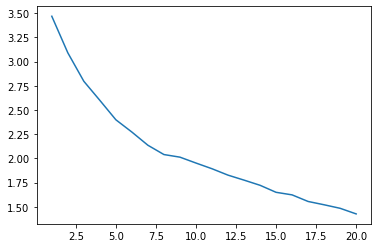

In [291]:
kmeans_inertia_list = []
maxk = 20
for i in range(maxk):
  kmeans = KMeans(init = "k-means++", n_clusters = i+1, random_state=0).fit(grouped_clustering)
  kmeans_inertia_list.append(kmeans.inertia_)
plt.plot([x+1 for x in list(range(maxk))], kmeans_inertia_list)

In [292]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(grouped_clustering)#fit clusters
regs_venues_sorted.insert(0, 'cluster_label', kmeans.labels_)

In [293]:
merged = df
merged = merged.join(regs_venues_sorted.set_index('reg'))
#merged = merged.dropna()
merged = merged.fillna(0)
merged['cluster_label'] = merged['cluster_label'].astype(int)
merged.head()

,lat,lon,cluster_label,1_most_common_venue,2_most_common_venue,3_most_common_venue,4_most_common_venue,5_most_common_venue,6_most_common_venue,7_most_common_venue,8_most_common_venue,9_most_common_venue,10_most_common_venue
reg,,,,,,,,,,,,,
0,29.644244,-95.537192,7,Gas Station,Fried Chicken Joint,Discount Store,Sandwich Place,Pizza Place,Convenience Store,Pharmacy,Furniture / Home Store,Shipping Store,Taco Place
1,29.644244,-95.518192,7,Gas Station,Discount Store,Fast Food Restaurant,Grocery Store,Pharmacy,Pizza Place,Sandwich Place,Mexican Restaurant,Food,Caribbean Restaurant
2,29.644244,-95.499192,7,Gas Station,Discount Store,Grocery Store,Mexican Restaurant,Breakfast Spot,Travel & Transport,Burger Joint,Fried Chicken Joint,Cajun / Creole Restaurant,Shoe Store
3,29.644244,-95.480192,2,Bank,Baseball Field,Donut Shop,Tennis Court,Theater,Paintball Field,Football Stadium,Salon / Barbershop,Hardware Store,Travel & Transport
4,29.644244,-95.461192,6,Grocery Store,Gas Station,Baseball Field,Bar,Bank,Sandwich Place,Resort,Event Service,Construction & Landscaping,Food Truck


In [294]:
map_clusters = folium.Map(location=[clat, clon], zoom_start=11)
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, poi, cluster in zip(merged['lat'], merged['lon'], merged.index.tolist(), merged['cluster_label']):
    out = 'Region '+str(poi)+', Cluster '+str(cluster)
    edges = [(lat+lat_spacing/2,lon-lon_spacing/2), (lat+lat_spacing/2,lon+lon_spacing/2), (lat-lat_spacing/2,lon+lon_spacing/2), (lat-lat_spacing/2,lon-lon_spacing/2)]
    map_clusters.add_child(folium.vector_layers.Polygon(locations=edges, color=rainbow[cluster-1], weight=0, fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.6, popup=(folium.Popup(out))))
map_clusters

Plot consists of rectangles with popup annotation indicating cluster number (and region number).  From my knoweldge of Houston, this breakdown seems pretty reasonable!  Folium plots do not appear in github, so please click [here](https://colab.research.google.com/drive/15bY7XFCpoIYk-i8eOJrR_AsS8t8Wn5qB?usp=sharing) to see the notebook/plot.

## Compare representation of different venues among peers
* Find the average number of each type of venue among cluster group
* Find the difference of each region relative to it's cluster peers

In [295]:
v_rep = onehot.groupby('reg').sum().astype(float)
cols = v_rep.columns
v_rep = regs_venues_sorted[['reg','cluster_label']].join(merged[['lat', 'lon']].join(v_rep))
v_rep_mean = v_rep.groupby('cluster_label').mean().iloc[:,3:]
v_rep = v_rep.merge(v_rep_mean, on='cluster_label', suffixes=['', '_avg']).set_index('reg')
for col in cols:
  v_rep[col] = v_rep[col]-v_rep[col+'_avg']
v_rep = v_rep.drop([x+'_avg' for x in cols], axis=1)

## Pick a few venue types and explore / plot

### All restaurants

A higher value will indicate an over-abundance of restaurants, while a lower value will indicate a dearth of restaurants (relative to peer group)

In [296]:
key = 'Restaurant'
key_rep = v_rep[[col for col in v_rep.columns if (key in col) | ('cluster_label' in col) | ('lat' in col) | ('lon' in col)]]
key_sum = pd.DataFrame(key_rep.iloc[:,3:].sum(axis=1), columns=[key])
key_rep = key_rep.iloc[:,:3].join(key_sum)
key_rep[key+'_scaled'] = MinMaxScaler().fit_transform(key_rep[key].values.reshape(-1, 1)) #need the reshape for a single column, else you do not.
key_rep.sort_values(key, ascending=False).head()

,cluster_label,lat,lon,Restaurant,Restaurant_scaled
reg,,,,,
52,1,29.729244,-95.499192,25.244444,1.000000
50,2,29.729244,-95.537192,20.722222,0.901691
30,2,29.695244,-95.537192,19.722222,0.879952
63,1,29.746244,-95.480192,19.244444,0.869565
42,2,29.712244,-95.499192,18.722222,0.858213


In [297]:
map_clusters = folium.Map(location=[clat, clon], zoom_start=11)
x = np.arange(n_clusters)
for reg, lat, lon, cluster, val, shade in zip(key_rep.index.tolist(), key_rep['lat'], key_rep['lon'], key_rep['cluster_label'], key_rep[key], key_rep[key+'_scaled']):
    try:
      out = 'R'+str(reg)+', #'+str(cluster)+', '+str(round(val,2))+', '+str(round(shade,2))+'%'
      edges = [(lat+lat_spacing/2,lon-lon_spacing/2), (lat+lat_spacing/2,lon+lon_spacing/2), (lat-lat_spacing/2,lon+lon_spacing/2), (lat-lat_spacing/2,lon-lon_spacing/2)]
      #folium.map.Marker([lat+lat_spacing, lon-lon_spacing], icon=DivIcon(icon_size=(150,36),icon_anchor=(0,0),html='<div style="font-size: 18pt">%s</div>' % out)).add_to(map_clusters)
      map_clusters.add_child(folium.vector_layers.Polygon(locations=edges, color='red', fill_color='red', weight=2, fill_opacity=shade*0.5, popup=(folium.Popup(out))))
    except: print('Error on region: '+str(cluster))
map_clusters

Shading density of rectangles indicates a surplus or dearth of restaurants.  No shading means not enough restaurants, dark shading means too many restaurants.  The shading values is maxmin scaled over the range.

### What types of venues are most under-represented?

Looks like Mexican Restaurants are under-represented in at least one region...

In [301]:
v_rep.iloc[:,3:].describe().loc['min'].sort_values(ascending=True).head(10)

Mexican Restaurant     -3.622222
Coffee Shop            -3.222222
Pizza Place            -3.153846
Sandwich Place         -2.861111
Fast Food Restaurant   -2.583333
Bar                    -2.488889
Grocery Store          -2.384615
American Restaurant    -2.355556
Italian Restaurant     -2.111111
Burger Joint           -1.977778
Name: min, dtype: float64

Several regions need more Mexican Restaurants!

In [299]:
v_rep[['lat', 'lon', 'Mexican Restaurant']].sort_values('Mexican Restaurant', ascending=True).head(10)

,lat,lon,Mexican Restaurant
reg,,,
85,29.780244,-95.442192,-3.622222
75,29.763244,-95.442192,-3.622222
74,29.763244,-95.461192,-3.622222
70,29.763244,-95.537192,-3.622222
101,29.814244,-95.518192,-3.076923
64,29.746244,-95.461192,-2.622222
47,29.712244,-95.404192,-2.622222
65,29.746244,-95.442192,-2.622222
59,29.729244,-95.366192,-2.622222
